In [1]:
import pandas as pd
import os

# Define column names
columns = ['patient_id', 'filename', 'class', 'data_source']

# Read the files
df_train = pd.read_csv('covidx/train.txt', sep=' ', header=None, names=columns)
df_train['split'] = 'train'

df_val = pd.read_csv('covidx/val.txt', sep=' ', header=None, names=columns)
df_val['split'] = 'val'

df_test = pd.read_csv('covidx/test.txt', sep=' ', header=None, names=columns)
df_test['split'] = 'test'

# Concatenate into a single dataframe
df = pd.concat([df_train, df_val, df_test], ignore_index=True)


# Display the first few rows
df.head()

,patient_id,filename,class,data_source,split
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen,train
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen,train
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen,train
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen,train
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen,train


In [2]:
# Display dataframe info
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 84818 entries, 0 to 84817
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   patient_id   84818 non-null  str  
 1   filename     84818 non-null  str  
 2   class        84818 non-null  str  
 3   data_source  84818 non-null  str  
 4   split        84818 non-null  str  
dtypes: str(5)
memory usage: 3.2 MB


In [3]:
# Check counts per split
df['split'].value_counts()

split
train    67863
test      8482
val       8473
Name: count, dtype: int64

In [4]:
# Calculate null values and percentages
null_counts = df.isnull().sum()
null_percentages = (df.isnull().sum() / len(df)) * 100

# Create a dataframe for better visualization
null_df = pd.DataFrame({'Null Count': null_counts, 'Percentage': null_percentages})

# Display columns with null values
print("Columns with null values:")
print(null_df[null_df['Null Count'] > 0].sort_values('Percentage', ascending=False))

print(f"\nNull values:\n{df.isnull().sum()}")

Columns with null values:
Empty DataFrame
Columns: [Null Count, Percentage]
Index: []

Null values:
patient_id     0
filename       0
class          0
data_source    0
split          0
dtype: int64


In [5]:
# Check for full row duplicates
print(f"Duplicate Rows: {df.duplicated().sum()}")

# Check for duplicate ImageIDs (should be unique ideally)
print(f"Duplicate ImageIDs: {df['filename'].duplicated().sum()}")

Duplicate Rows: 0
Duplicate ImageIDs: 0


In [6]:
# Construct full file paths
# Assumes images are in 'covidx/split/filename' based on folder structure seen previously
df['filepath'] = 'covidx/' + df['split'] + '/' + df['filename']

# Check if file exists
df['file_exists'] = df['filepath'].apply(os.path.exists)

# Count missing files
missing_count = (~df['file_exists']).sum()
print(f"Missing Images: {missing_count}")

# Display missing images if any
if missing_count > 0:
    print("\nExample missing files:")
    print(df[~df['file_exists']].head())

Missing Images: 0


In [7]:
from PIL import Image
from tqdm import tqdm

def check_image_corruption(path):
    try:
        with Image.open(path) as img:
            img.verify() # Verify it's an image
        return False # Not corrupted
    except Exception:
        return True # Corrupted

# We will use tqdm to show progress as there are many images
# tqdm.pandas() caused issues, so we use a standard loop with tqdm

print("Checking for image corruption...")
# Apply the check only to existing files to avoid re-flagging missing ones
# df['is_corrupted'] = df['filepath'].progress_apply(check_image_corruption)

# Alternative robust method
results = [check_image_corruption(path) for path in tqdm(df['filepath'])]
df['is_corrupted'] = results

corrupted_count = df['is_corrupted'].sum()
print(f"Corrupted Images: {corrupted_count}")

if corrupted_count > 0:
    print("\nExample corrupted files:")
    print(df[df['is_corrupted']].head())

Checking for image corruption...


100%|██████████| 84818/84818 [01:11<00:00, 1180.45it/s]

Corrupted Images: 0


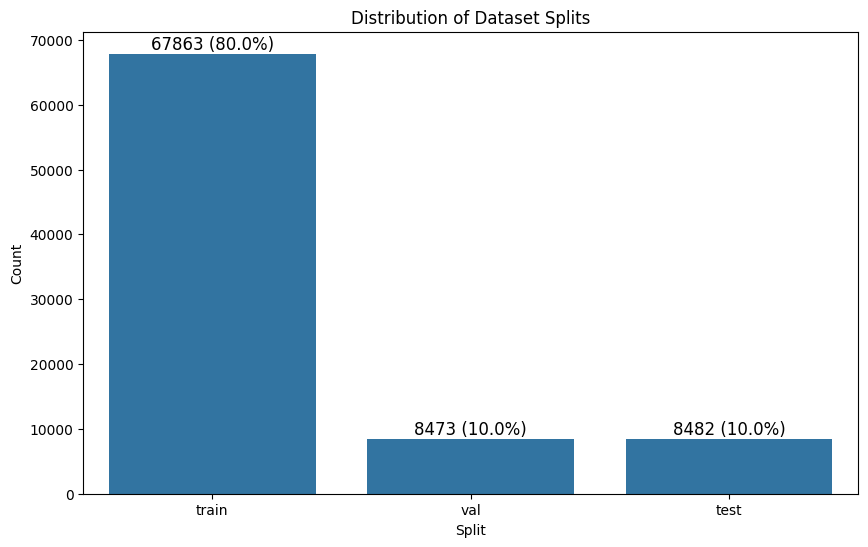

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns


# Plot the distribution of splits with percentages
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='split', data=df, order=['train', 'val', 'test'])
plt.title('Distribution of Dataset Splits')
plt.xlabel('Split')
plt.ylabel('Count')

# Calculate total for percentages
total = len(df)

# Add count and percentage labels
for p in ax.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count} ({percentage})', (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

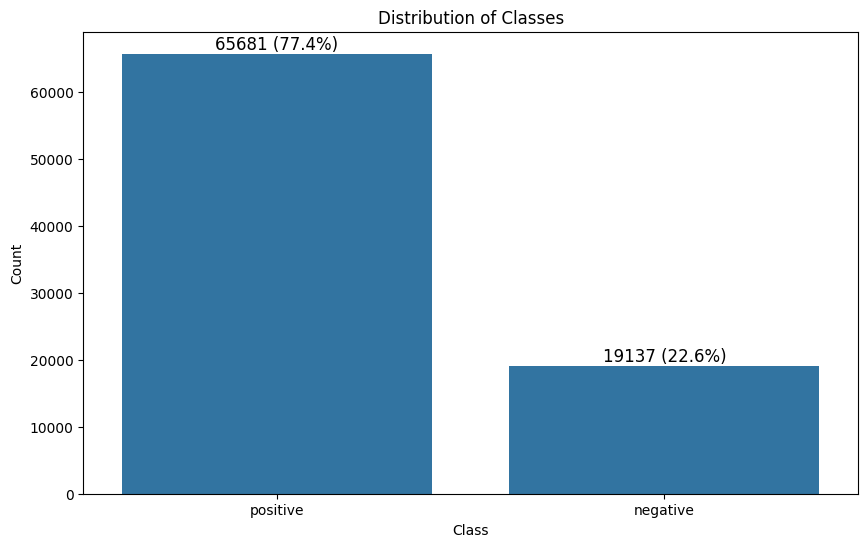

In [12]:
# Plot the distribution of classes with percentages
plt.figure(figsize=(10, 6))
class_counts = df['class'].value_counts()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')

# Calculate total for percentages
total = len(df)

# Add count and percentage labels
for p in ax.patches:
    count = int(p.get_height())
    percentage = '{:.1f}%'.format(100 * count / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(f'{count} ({percentage})', (x, y), ha='center', va='bottom', fontsize=12)

plt.show()

Images per Patient Summary:
count    45342.000000
mean         1.870628
std          4.599203
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max        236.000000
Name: filename, dtype: float64


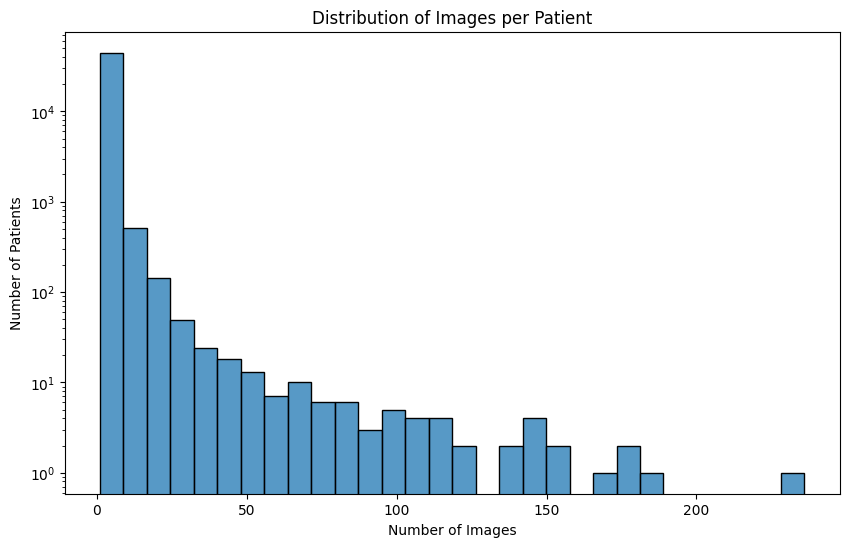


Top 10 Patients by Image Count:
patient_id
A860070    236
A763364    183
A221230    175
A701295    174
A766483    173
A002052    151
A558243    150
A727037    148
A973206    147
A438102    146
Name: filename, dtype: int64


In [13]:
# Analyze Images per Patient

# Group by patient_id and count images
images_per_patient = df.groupby('patient_id')['filename'].count().sort_values(ascending=False)

# Summary statistics
print("Images per Patient Summary:")
print(images_per_patient.describe())

# Plot distribution
plt.figure(figsize=(10, 6))
sns.histplot(images_per_patient, bins=30, kde=False)
plt.title('Distribution of Images per Patient')
plt.xlabel('Number of Images')
plt.ylabel('Number of Patients')
plt.yscale('log')  # Use log scale as some patients might have many images
plt.show()

# Show top patients
print("\nTop 10 Patients by Image Count:")
print(images_per_patient.head(10))


In [14]:
images_per_patient['389']

np.int64(6)

In [15]:
df.loc[df['patient_id'] == '389']

,patient_id,filename,class,data_source,split,filepath,file_exists,is_corrupted
20,389,19a01707.jpg,negative,cohen,train,covidx/train/19a01707.jpg,True,False
21,389,bf551b8b.jpg,negative,cohen,train,covidx/train/bf551b8b.jpg,True,False
22,389,1e534853.jpg,negative,cohen,train,covidx/train/1e534853.jpg,True,False
23,389,aa9655de.jpg,negative,cohen,train,covidx/train/aa9655de.jpg,True,False
24,389,073a8f93.jpg,negative,cohen,train,covidx/train/073a8f93.jpg,True,False
25,389,7a9ec606.jpg,negative,cohen,train,covidx/train/7a9ec606.jpg,True,False


Images per Data Source:
data_source
bimcv         54632
rsna          13788
stonybrook    13636
ricord         1096
sirm            943
cohen           567
actmed          132
fig1             24
Name: filename, dtype: int64


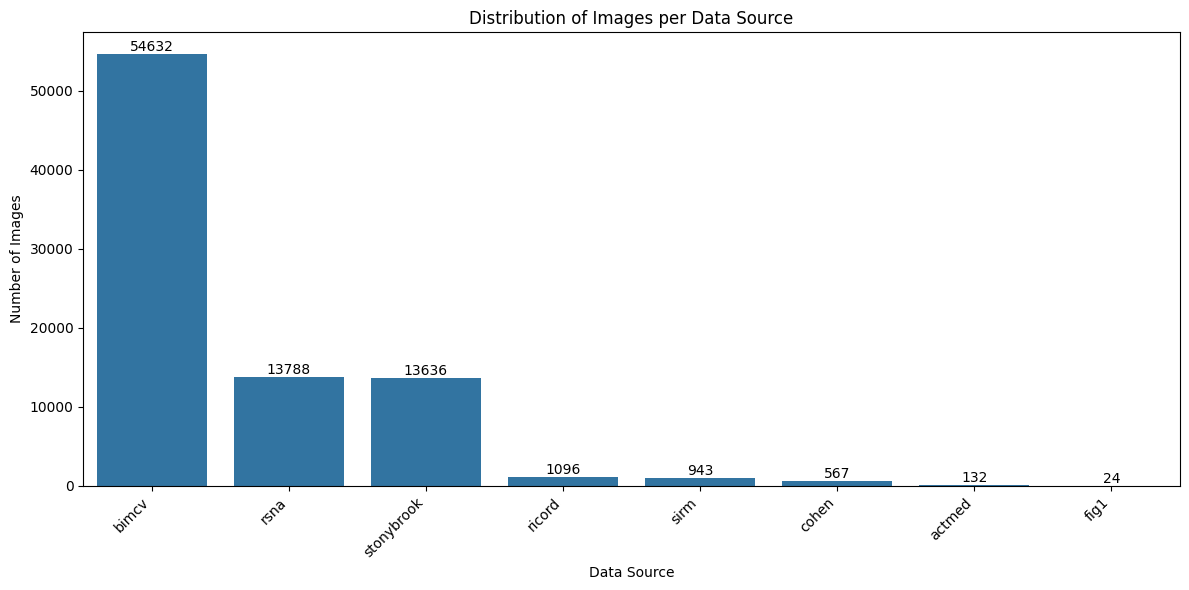

In [16]:
# Analyze Images per Data Source

# Group by data_source and count images
images_per_source = df.groupby('data_source')['filename'].count().sort_values(ascending=False)

# Summary statistics
print("Images per Data Source:")
print(images_per_source)

# Plot distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=images_per_source.index, y=images_per_source.values)
plt.title('Distribution of Images per Data Source')
plt.xlabel('Data Source')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')

# Add labels
for i, v in enumerate(images_per_source.values):
    plt.text(i, v + 10, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [17]:
# Extract projection (AP/PA) from filename
# Note: 'p' is not a valid hex character (0-9, a-f), so 'ap'/'pa' substrings are safe to search.

def extract_projection(filename):
    fname = str(filename).lower()
    if 'ap' in fname:
        return 'AP'
    elif 'pa' in fname:
        return 'PA'
    return 'Unknown'

df['projection'] = df['filename'].apply(extract_projection)

# Display counts
print("Projection counts:")
print(df['projection'].value_counts())

# Show sample of extracted views
print("\nSample with projection:")
print(df[df['projection'] != 'Unknown'][['filename', 'projection']].head())


Projection counts:
projection
AP         39951
PA         25069
Unknown    19798
Name: count, dtype: int64

Sample with projection:
                                filename projection
252      parapneumonic-effusion-1-PA.png         AP
253  right-upper-lobe-pneumonia-9-PA.jpg         PA
254           chlamydia-pneumonia-PA.png         PA
259   cavitating-pneumonia-4-day0-PA.jpg         PA
260  cavitating-pneumonia-4-day28-PA.png         PA


Total Projection Counts:
projection
AP         39951
PA         25069
Unknown    19798
Name: count, dtype: int64

Total Projection Percentages:
projection
AP         47.10
PA         29.56
Unknown    23.34
Name: proportion, dtype: float64


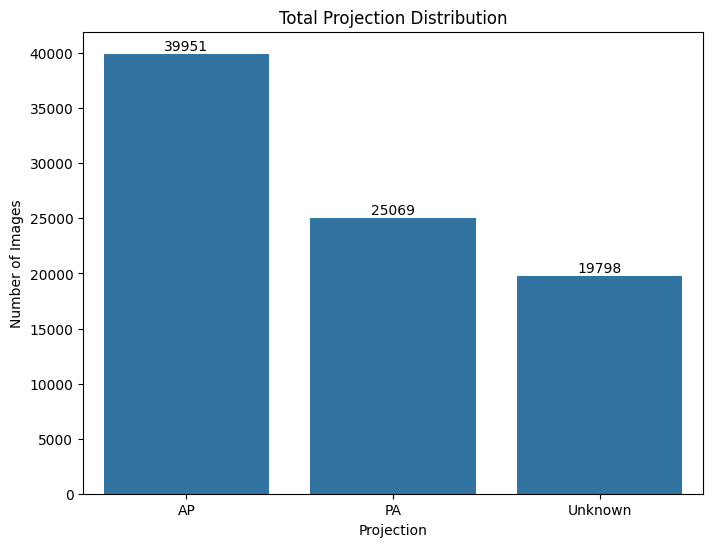

In [18]:
# Analyze Total Projection Distribution

# Calculate counts and percentages
total_proj_counts = df['projection'].value_counts()
total_proj_pct = df['projection'].value_counts(normalize=True) * 100

print("Total Projection Counts:")
print(total_proj_counts)
print("\nTotal Projection Percentages:")
print(total_proj_pct.round(2))

# Plot distribution
plt.figure(figsize=(8, 6))
ax = sns.barplot(x=total_proj_counts.index, y=total_proj_counts.values)
plt.title('Total Projection Distribution')
plt.xlabel('Projection')
plt.ylabel('Number of Images')

# Add count labels on top of bars
for i, v in enumerate(total_proj_counts.values):
    ax.text(i, v + 50, str(v), ha='center', va='bottom')

plt.show()

Projection Counts per Data Source:
projection      AP     PA  Unknown
data_source                       
actmed           0      0      132
bimcv        26303  25051     3278
cohen           12     18      537
fig1             0      0       24
ricord           0      0     1096
rsna             0      0    13788
sirm             0      0      943
stonybrook   13636      0        0

Projection Percentages per Data Source:
projection       AP     PA  Unknown
data_source                        
actmed         0.00   0.00   100.00
bimcv         48.15  45.85     6.00
cohen          2.12   3.17    94.71
fig1           0.00   0.00   100.00
ricord         0.00   0.00   100.00
rsna           0.00   0.00   100.00
sirm           0.00   0.00   100.00
stonybrook   100.00   0.00     0.00


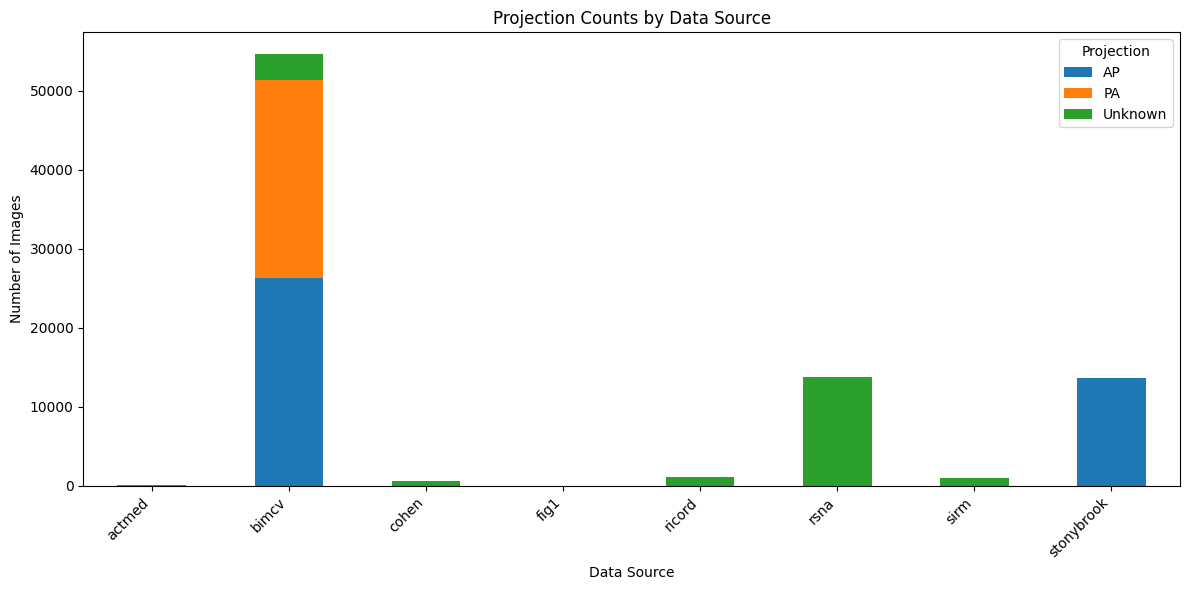

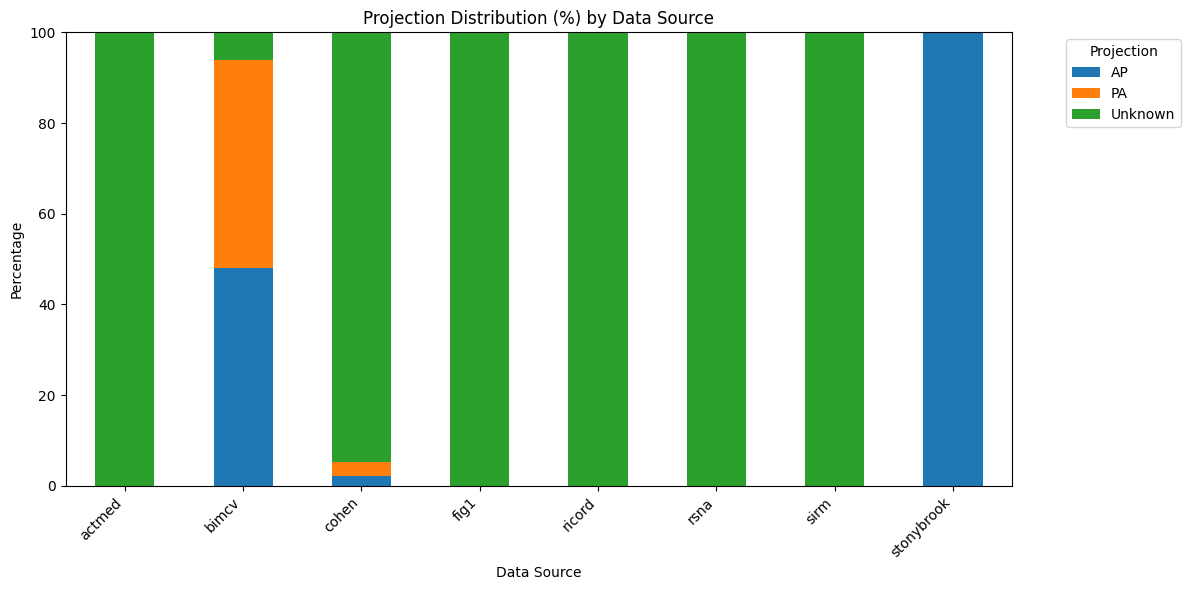

In [19]:
# Analyze Projection Distribution per Data Source

# Create crosstab for counts
ct_counts = pd.crosstab(df['data_source'], df['projection'])
print("Projection Counts per Data Source:")
print(ct_counts)

# Create crosstab for percentages (normalize along index/rows)
ct_pct = pd.crosstab(df['data_source'], df['projection'], normalize='index') * 100
print("\nProjection Percentages per Data Source:")
print(ct_pct.round(2))

# Plot stacked bar chart for counts
plt.figure(figsize=(12, 6))
ct_counts.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Projection Counts by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Number of Images')
plt.legend(title='Projection')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Plot stacked bar chart for percentages
plt.figure(figsize=(12, 6))
ct_pct.plot(kind='bar', stacked=True, ax=plt.gca())
plt.title('Projection Distribution (%) by Data Source')
plt.xlabel('Data Source')
plt.ylabel('Percentage')
plt.legend(title='Projection', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [20]:
df.to_csv('covidx_merged.csv', index=False)